# SymPy and Theano - Code Generation

Following:

http://matthewrocklin.com/blog/work/2013/03/19/SymPy-Theano-part-1/

and 

http://docs.sympy.org/latest/tutorial/printing.html

and

http://mattpap.github.io/scipy-2011-tutorial/html/printers.html

Using Python 2...

## Physics

SymPy knows physics - here is the radial wavefunction corresponding to `n = 3` and `l = 1` for Carbon:

In [1]:
import sympy
from sympy import init_printing
init_printing()

In [2]:
from sympy.physics.hydrogen import R_nl
from sympy.abc import x

expr = R_nl(3, 1, x, 6)      # Z = 6
print sympy.latex(expr)

\frac{8 x}{3} \left(- 4 x + 4\right) e^{- 2 x}


In [3]:
sympy.pprint(expr)

                -2⋅x
8⋅x⋅(-4⋅x + 4)⋅ℯ    
────────────────────
         3          


In [4]:
f = sympy.sympify('x^2 + sin(y) + 1/2')
print f

x**2 + sin(y) + 1/2


In [5]:
sympy.pprint(expr, use_unicode=True)

                -2⋅x
8⋅x⋅(-4⋅x + 4)⋅ℯ    
────────────────────
         3          


In [6]:
sympy.latex(expr)

'\\frac{8 x}{3} \\left(- 4 x + 4\\right) e^{- 2 x}'

In [7]:
print sympy.printing.latex(expr)

\frac{8 x}{3} \left(- 4 x + 4\right) e^{- 2 x}


In [8]:
from IPython.display import Latex

In [9]:
Latex(sympy.latex(expr))

<IPython.core.display.Latex object>

In [10]:
Latex(str(sympy.latex(expr)))

<IPython.core.display.Latex object>

## Numerics

SymPy is not as good at numerical computation. But, we can offload the work to numerical projects like `numpy` or generate and compile straight `Fortran` code.

In [11]:
from sympy.utilities.autowrap import ufuncify
from sympy.utilities.lambdify import lambdify

In [12]:
fn_numpy = lambdify(x, expr, 'numpy')
fn_fortran = ufuncify([x], expr)

`fn_numpy` replaces the SimPy operations with the equivalent function from NumPy. `fn_fortran` generates and compiles low-level Fortran code and uses `f2py` to bind it to a Python function. They both use `numpy` arrays as common data structures, therefore supporting interoperability with the rest of the Scientific Python ecosystem.

In [13]:
from numpy import linspace

In [14]:
xx = linspace(0, 1, 5)

In [15]:
fn_numpy(xx)

array([ 0.        ,  1.21306132,  0.98101184,  0.44626032,  0.        ])

In [16]:
fn_fortran(xx)

array([ 0.        ,  1.21306132,  0.98101184,  0.44626032,  0.        ])

In [17]:
from pylab import plot, show, legend

In [18]:
%matplotlib inline

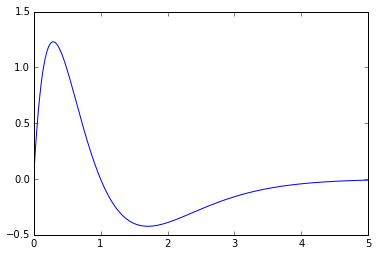

In [19]:
xx = linspace(0, 5, 50000)
plot(xx, fn_numpy(xx))

## Performance

The Fortran is a bit faster than the NumPy because it is able to fuse all the scalar operations into one loop while the NumPy solution has to walk over memory several times and perform each operation individually:

In [20]:
%timeit fn_numpy(xx)

1000 loops, best of 3: 699 µs per loop


In [21]:
%timeit fn_fortran(xx)

1000 loops, best of 3: 591 µs per loop


In [22]:
from sympy.printing.theanocode import theano_function

In [23]:
fn_theano = theano_function([x], [expr], dims={x: 1}, dtypes={x: 'float64'})

In [24]:
%timeit fn_theano(xx)

1000 loops, best of 3: 529 µs per loop


Theano generates C code - it incurs some startup time, but then is quite fast and it is able to compile these expressions to work on a GPU.

## Leveraging Theano

In [25]:
outputs = expr, sympy.simplify(expr.diff(x))

In [26]:
sympy.pprint(outputs, use_unicode=True)

⎛                -2⋅x  ⎛    2             ⎞  -2⋅x⎞
⎜8⋅x⋅(-4⋅x + 4)⋅ℯ      ⎝64⋅x  - 128⋅x + 32⎠⋅ℯ    ⎟
⎜────────────────────, ──────────────────────────⎟
⎝         3                        3             ⎠


In [27]:
sympy.pprint(outputs, use_unicode=False)

                 -2*x  /    2             \  -2*x 
 8*x*(-4*x + 4)*e      \64*x  - 128*x + 32/*e     
(--------------------, --------------------------)
          3                        3              


In [28]:
print sympy.latex(outputs)

\left ( \frac{8 x}{3} \left(- 4 x + 4\right) e^{- 2 x}, \quad \frac{1}{3} \left(64 x^{2} - 128 x + 32\right) e^{- 2 x}\right )


Let's redefine our functions to produce both outputs:

In [29]:
fn_numpy = lambdify([x], outputs, 'numpy')
fn_theano = theano_function([x], outputs, dims={x: 1}, dtypes={x: 'float64'})
fns_fortran = [ufuncify([x], output) for output in outputs]
fn_fortran = lambda xx: [fn_fortran(xx) for fn_fortran in fns_fortran]

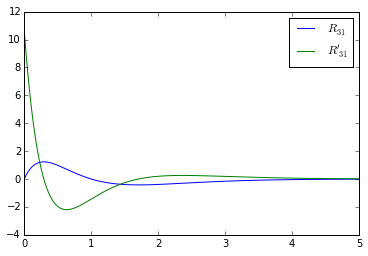

In [30]:
for y in fn_theano(xx):
    plot(xx, y)
legend(['$R_{31}$', "$R'_{31}$"])

In [31]:
%timeit fn_numpy(xx)

1000 loops, best of 3: 1.41 ms per loop


In [32]:
%timeit fn_fortran(xx)

1000 loops, best of 3: 1.18 ms per loop


In [33]:
%timeit fn_theano(xx)

1000 loops, best of 3: 552 µs per loop


Theano is able to go faster here because it removes extraneous common subexpressions in the compiled graph and so it needs to perform only the truly additional computations. 